# Yongjie's CA2-Unsupervised Model

Name: Li Yongjie

ID: 2342377

Class: DAAA/FT/1B/01

## Objective
Use unsupervised learning to group the students into multiple clusters so that we can cater needs
for different students

<hr>

### Importing the neccessary libraries

In [45]:
os.environ["OMP_NUM_THREADS"] = "1" # Set this before importing sklearn

# Basic Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Sklearn Libraries
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



df = pd.read_csv("./Student_Performance_dataset.csv")

print(df.head(5))

   Student_ID  Gender  Age  English_Score  Math_Score  Science_Score
0           1  Female   18           64.0        56.0             60
1           2  Female   12           89.0        71.0             97
2           3  Female   18           69.0        69.0             80
3           4  Female   17           60.0        72.0             97
4           5    Male   13           71.0        76.0             76


In [3]:
sns.set_theme(palette='bright')
# Set the style for plots
plt.style.use('seaborn-v0_8-darkgrid')

<hr>

## Exploratory Data Analysis
<hr>

We will conduct an exploratory data analysis to gain insights into the characteristics of the dataset. Our focus will primarily be on understanding how each feature relates to the one another and try to identify paterns or trends.

This dataset pertains to student performance and contains 1000 data points with 6 columns:

*   **Student\_ID**: Unique identifier for each student
*   **Gender**: Student's gender
*   **Age**: Student's age
*   **English\_Score**: Student's score in English subject
*   **Math\_Score**: Student's score in Math subject
*   **Science\_Score**: Student's score in Science subject

Since Student ID is a unique identifier I dropped the column first

In [51]:
df.drop(columns='Student_ID', inplace=True)

### **Exploring Dataset**

In order to prevent our data set from being affected when exploring the dataset, we will create a copy of the original dataset

In [52]:
df_eda = df.copy()

In [53]:
# Get description 
df_eda.describe()

,Age,English_Score,Math_Score,Science_Score
count,1000.000000,971.000000,967.000000,1000.000000
mean,14.970000,76.089598,76.660807,76.370000
std,1.959832,12.767113,12.541226,12.866649
min,12.000000,55.000000,55.000000,55.000000
25%,13.000000,65.000000,66.000000,65.000000
50%,15.000000,76.000000,76.000000,77.000000
75%,17.000000,88.000000,87.500000,87.000000
max,18.000000,98.000000,98.000000,98.000000


In [54]:
df_eda.dtypes

Gender            object
Age                int64
English_Score    float64
Math_Score       float64
Science_Score      int64
dtype: object

In [55]:
df_eda['Gender'].unique()

array(['Female', 'Male', 'Genderqueer', 'Non-binary', 'Agender',
       'Bigender', 'Genderfluid', 'Polygender'], dtype=object)

In [56]:
df_eda.isnull().sum()

Gender            0
Age               0
English_Score    29
Math_Score       33
Science_Score     0
dtype: int64

In [57]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         1000 non-null   object 
 1   Age            1000 non-null   int64  
 2   English_Score  971 non-null    float64
 3   Math_Score     967 non-null    float64
 4   Science_Score  1000 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB


Based on the information we collected, we can observe that the dataset we are working with contains 1000 rows and 4 columns (4 features).

We can tell that 3 features are numerical and that we have one categorical data that we need to handle. However, there are missing values for 2 of the columns which has to be handled with later on. Columns that have missing data includes, English Score - 29(2.9%), Math Score - 33(3.3%)

<hr>

### Univariate Analyisis
<hr>

Analysing our feature one at a time, to gain a better understanding of the feature and its distribution.

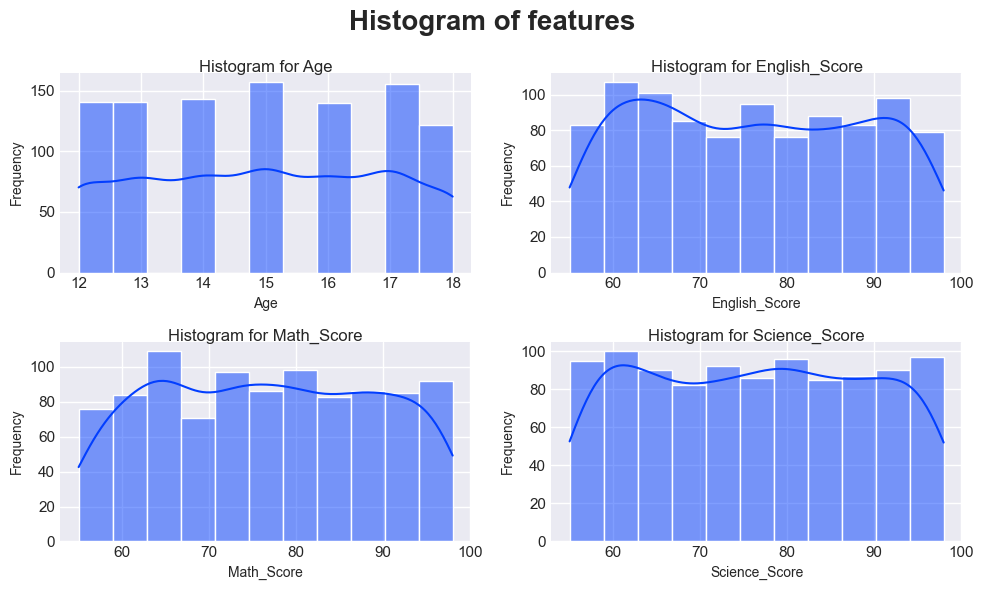

In [10]:
fig, axs = plt.subplots(2, 2 , tight_layout=False, figsize=(10, 6))

for i, (col, ax) in enumerate(zip(df_eda.columns[1:], axs.flatten())):
    sns.histplot(df[col], ax=ax, kde=True)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(f"Histogram for {col}", fontsize=12, pad=0.4)
    
plt.suptitle("Histogram of features", fontsize=20, fontweight='bold')
plt.show()

**Summary for feature's and it's graph**
<ol>
    <li>We can see that the distribution of each feature are similar in the sense that they all all almost equally distributed</li>
    <li>For scores we can observe that the scores are well-distributed over the range of 55-100</li>
    <li>For age we can observe that the ages are well-distributed over the range of 12-18</li>
</ol>


<u>Box Plot</u><br>
To observe outliers

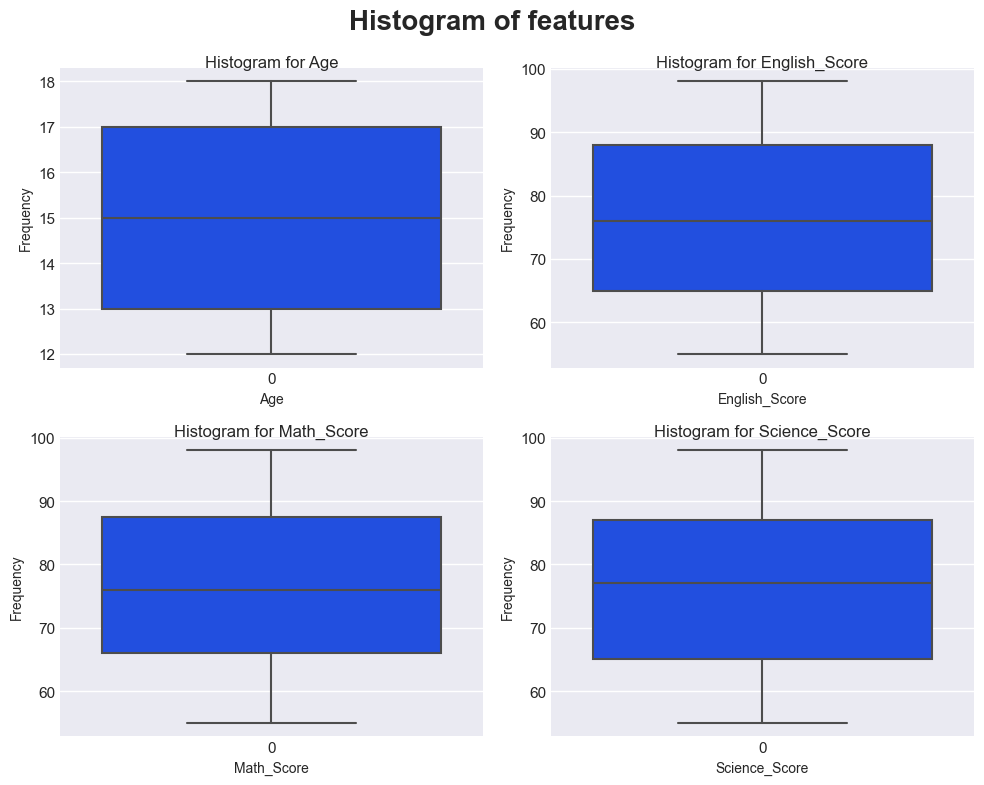

In [11]:
fig, axs = plt.subplots(2, 2 , tight_layout=False, figsize=(10, 8))

for i, (col, ax) in enumerate(zip(df_eda.columns[1:], axs.flatten())):
    sns.boxplot(df[col], ax=ax)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(f"Histogram for {col}", fontsize=12, pad=0.4)
    
plt.suptitle("Histogram of features", fontsize=20, fontweight='bold')
plt.show()

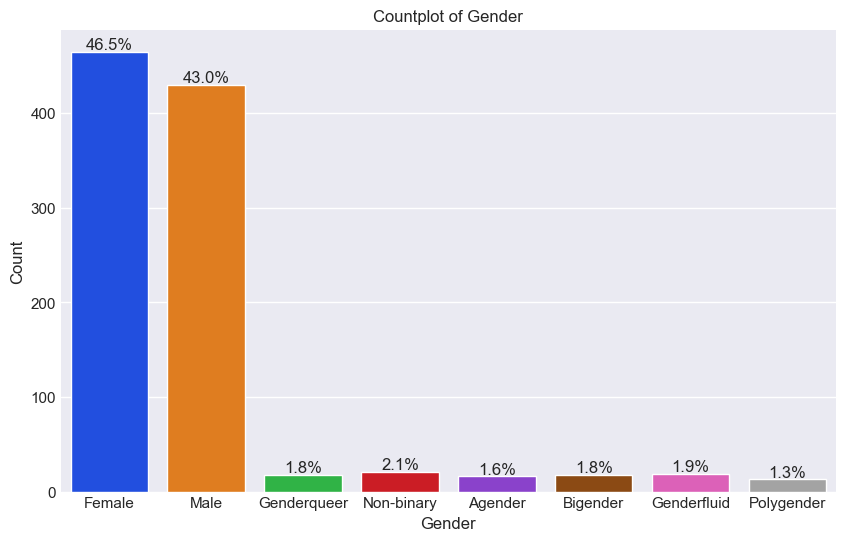

In [12]:
# Calculate the percentage of each gender
percentages = df['Gender'].value_counts(normalize=True) * 100

# Plot the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Gender')

# Add percentages as text labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(df)*100:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax.set(xlabel='Gender', ylabel='Count')
plt.title('Countplot of Gender')
plt.show()

In [13]:
def groupNonBinaryGender(name):
    if name != 'Female' and name!= "Male":
        return "Others"
    else:
        return name
    
df['Gender'] = df['Gender'].apply(groupNonBinaryGender)

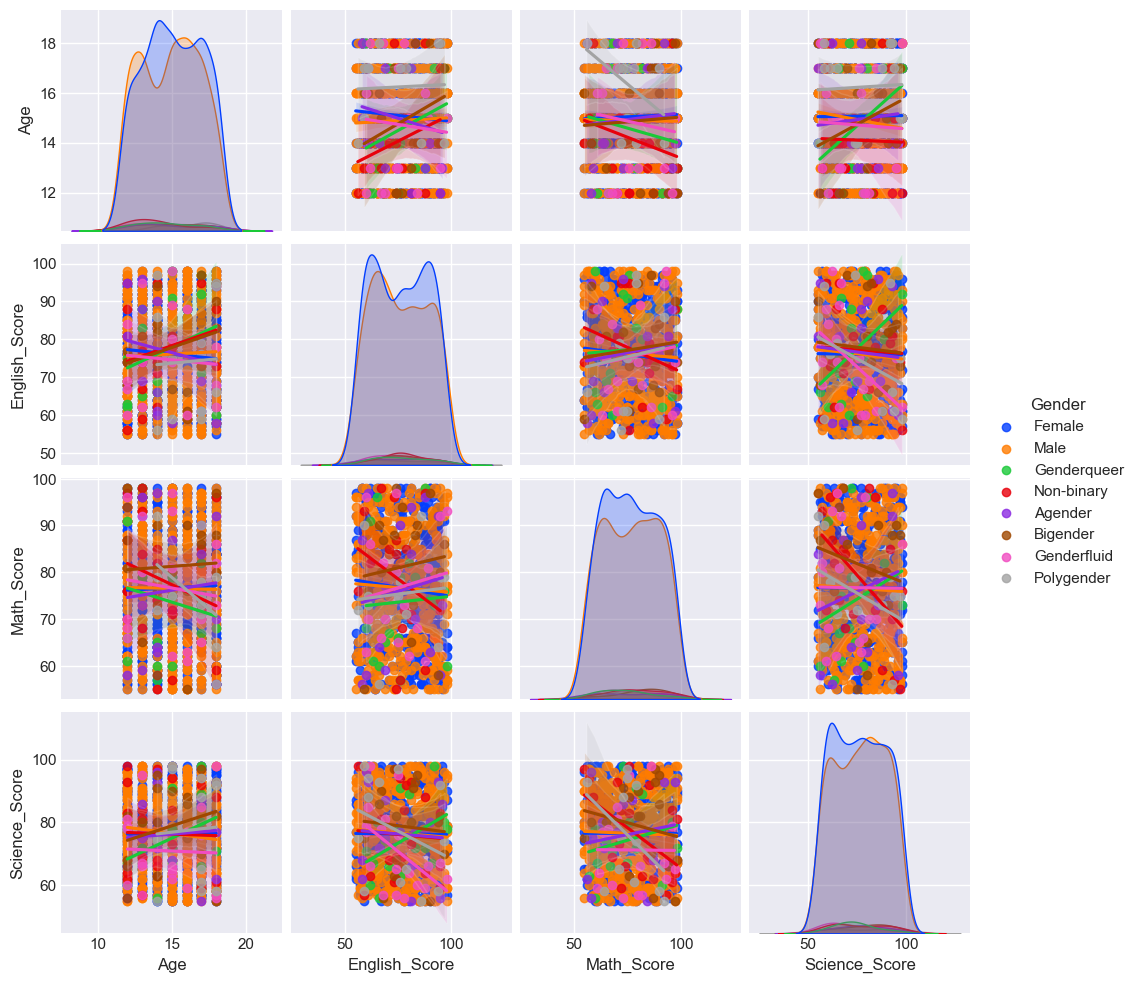

In [14]:
sns.pairplot(df_eda, kind='reg', hue='Gender')
plt.show()

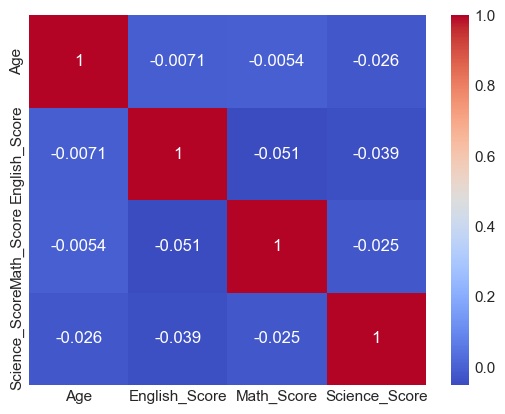

In [15]:
sns.heatmap(df_eda.drop(columns='Gender').corr(), annot=True, cmap='coolwarm')
plt.show()

### Imputing missing data

In [16]:
from sklearn.impute import SimpleImputer
cols = ['English_Score', 'Math_Score']
imputer = SimpleImputer(strategy='mean')
df.loc[:,cols] = imputer.fit_transform(df[cols])

### Getting average score

In [17]:
df['Average score'] = df[['English_Score', 'Math_Score', 'Science_Score']].mean(axis=1)
df

,Gender,Age,English_Score,Math_Score,Science_Score,Average score
0,Female,18,64.0,56.0,60,60.000000
1,Female,12,89.0,71.0,97,85.666667
2,Female,18,69.0,69.0,80,72.666667
3,Female,17,60.0,72.0,97,76.333333
4,Male,13,71.0,76.0,76,74.333333
...,...,...,...,...,...,...
995,Female,14,64.0,55.0,77,65.333333
996,Others,14,66.0,60.0,56,60.666667
997,Male,16,82.0,81.0,74,79.000000
998,Male,14,76.0,62.0,62,66.666667


### Scaling the data

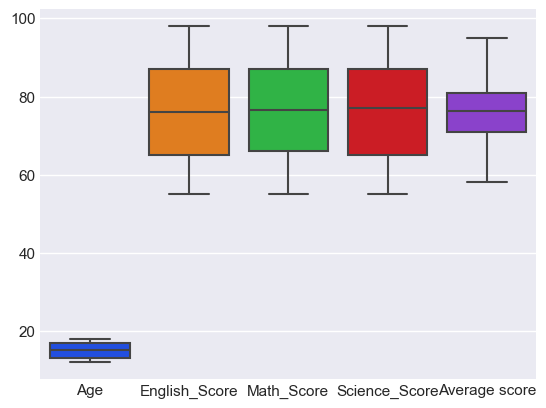

In [18]:
sns.boxplot(df)
plt.show()

In [19]:
scale = StandardScaler()
col=list(df.drop(columns='Gender').columns)
df_scaled = df.copy()
df_scaled[col] = scale.fit_transform(df_scaled[col])

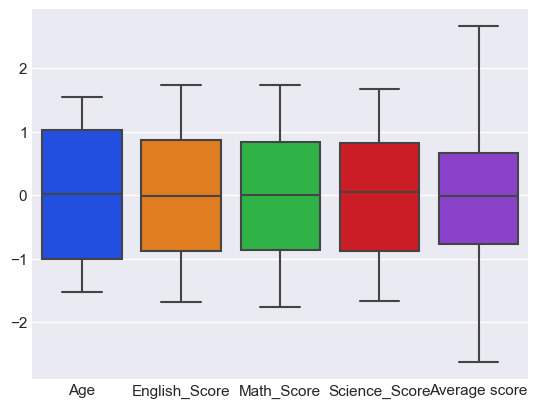

In [20]:
sns.boxplot(df_scaled)
plt.show()

### K-means Clustering

In [21]:
df_scaled.drop(columns={"Gender"}, inplace=True)

In [22]:
df_scaled.rename(columns={"English_Score": "Eng", "Math_Score": "Math", "Science_Score":"Sci", "Average score": "Avg", "Gender_Male":"Male", "Gender_Others":"Others"}, inplace=True)

In [23]:
df_scaled = pd.get_dummies(df_scaled)
df_scaled

,Age,Eng,Math,Sci,Avg
0,1.546825,-0.961465,-1.676173,-1.272918,-2.341717
1,-1.516194,1.026742,-0.459251,1.604172,1.329104
2,1.546825,-0.563823,-0.621507,0.282266,-0.530143
3,1.036321,-1.279578,-0.378123,1.604172,-0.005740
4,-1.005691,-0.404767,-0.053610,-0.028771,-0.291778
...,...,...,...,...,...
995,-0.495188,-0.961465,-1.757301,0.048988,-1.578949
996,-0.495188,-0.802408,-1.351660,-1.583955,-2.246371
997,0.525818,0.470044,0.352031,-0.184289,0.375644
998,-0.495188,-0.007126,-1.189404,-1.117400,-1.388257


<hr>

### Finding K

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples

def plot_optimalK(data):
    # Calculate the within-cluster sum of squares (inertia) for different number of clusters
    inertia = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=10).fit(data)
        inertia.append(kmeans.inertia_)

    # Calculate siholute scores
    scores = []
    k_list = []
    for i, k in enumerate(np.arange(2,15)):
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(data)
        cluster_labels = kmeans.labels_

        # Calculate the silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)

        # Compute the silhoutte scores for each sample
        sample_silhoutte_values = silhouette_samples(data, cluster_labels)
        scores.append(silhouette_avg)
        k_list.append(k)
        
    fig, ax = plt.subplots(1,2, figsize=(12, 4))

    ax[0].set_title("Elbow Method For Optimal k")
    ax[0].set_xlabel("Inertia")
    ax[0].plot(range(1,15), inertia, marker='o', linestyle='-')

    ax[1].set_title("Silhouette Coefficient")
    ax[1].set_ylabel("Silhouette Coefficient")
    ax[1].set_xlabel("k")
    sns.lineplot(y=scores, x=k_list, marker='o', ax=ax[1])

    plt.suptitle("Fidning Optimal K")

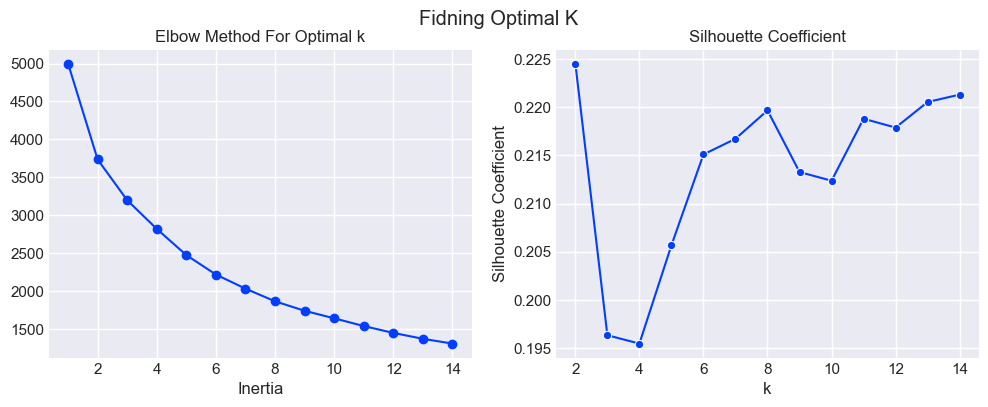

In [25]:
plot_optimalK(df_scaled)

In [26]:
df_pca = df_scaled.copy()
df_pca

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(df_scaled)
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f"PC{i+1}" for i in range(2)])

# Display the PCA results
print("\nPCA Results:")
pca_df


PCA Results:


,PC1,PC2
0,-3.303930,0.526815
1,1.904533,0.565820
2,-0.777502,-0.095636
3,-0.006233,-1.170872
4,-0.364724,-0.361593
...,...,...
995,-2.157482,0.096999
996,-3.107008,0.423611
997,0.493783,0.278530
998,-1.921196,0.865623


In [27]:
palette = ['#211C6A', '#59B4C3','#74E291', '#9F70FD', '#294B29', '#E3651D', 'red', 'blue']

def plot_loading_plot(data, pca, width=5, height=5, margin=0.25, ax=None):
    # Set limits for figure
    x_min = min(pca.components_[0, :].min(), 0)-margin
    x_max = max(pca.components_[0, :].max(), 0)+margin
    y_min = min(pca.components_[1, :].min(), 0)-margin
    y_max = max(pca.components_[1, :].max(), 0)+margin
    if ax is None:
        fig, ax = plt.subplots(figsize=(width, height))
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    # Give each component own color for legend
    for i, v in enumerate(pca.components_.T):
        ax.arrow(0, 0, v[0], v[1], head_width=0.05,
                 head_length=0.1, linewidth=2, color=palette[i], label=data.columns[i])
   
    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Loading plot", fontweight='bold')
    plt.legend(
        loc='upper left',
        bbox_to_anchor=(1, 1),
        fancybox=True,
        shadow=True,
        ncol=2)
    return ax

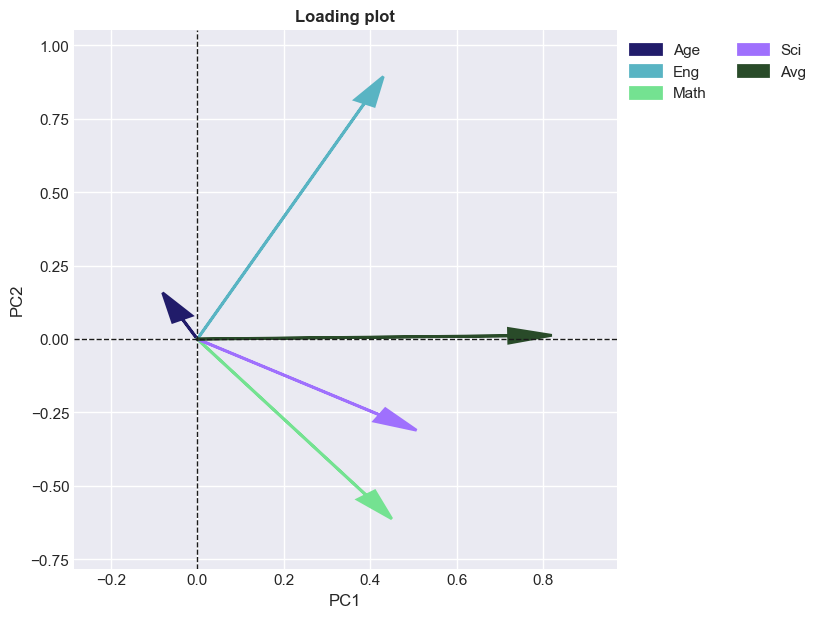

In [28]:
plt.clf
plot_loading_plot(df_scaled, pca, width=7, height=7)
plt.show() 

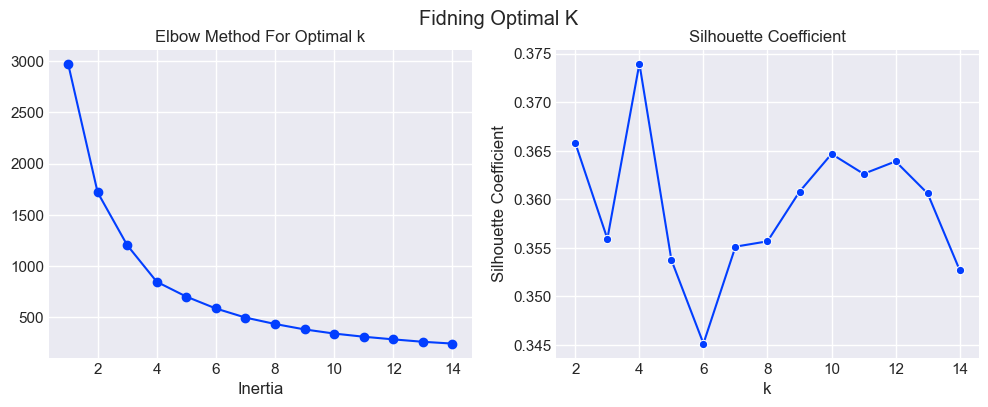

In [29]:
plot_optimalK(pca_df)

In [30]:
optimal_perplexity = round(np.sqrt(df_scaled.shape[0]))
tsne = TSNE(learning_rate=50, perplexity=optimal_perplexity, random_state=42)
tsne_features = pd.DataFrame(tsne.fit_transform(df_scaled))
tsne_features

,0,1
0,-33.615574,4.172704
1,10.819115,0.263783
2,6.512330,-15.421577
3,10.656084,-19.236551
4,-6.408441,0.400578
...,...,...
995,-17.588997,-4.563219
996,-32.077431,-7.461495
997,14.861605,12.111730
998,-16.960491,14.663007


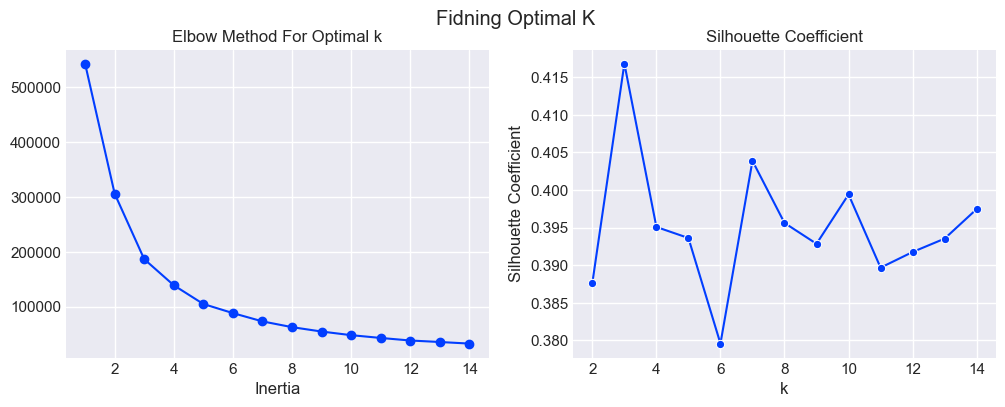

In [31]:
plot_optimalK(tsne_features)

<hr>

### K-Means Clustering
<hr>

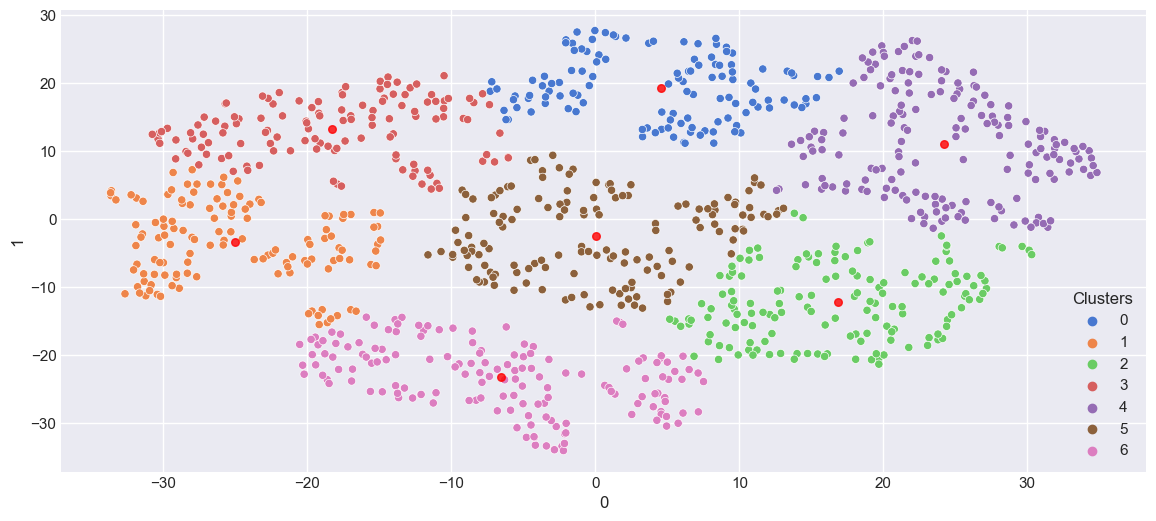

Silhouette Score(n=6): 0.4038631319999695


In [32]:
# fit a Kmeans model to the data
kMeansModel = KMeans(n_clusters=7, n_init=10)
kMeansModel.fit(tsne_features)

# Visualize the results
plt.figure(figsize=(14,6))
sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=kMeansModel.labels_, palette='muted')

centers = kMeansModel.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=30, alpha=0.8)
plt.legend(title='Clusters')
plt.show()

print(f'Silhouette Score(n=6): {silhouette_score(tsne_features, kMeansModel.labels_)}')

<hr>

### Hierichal Clustering

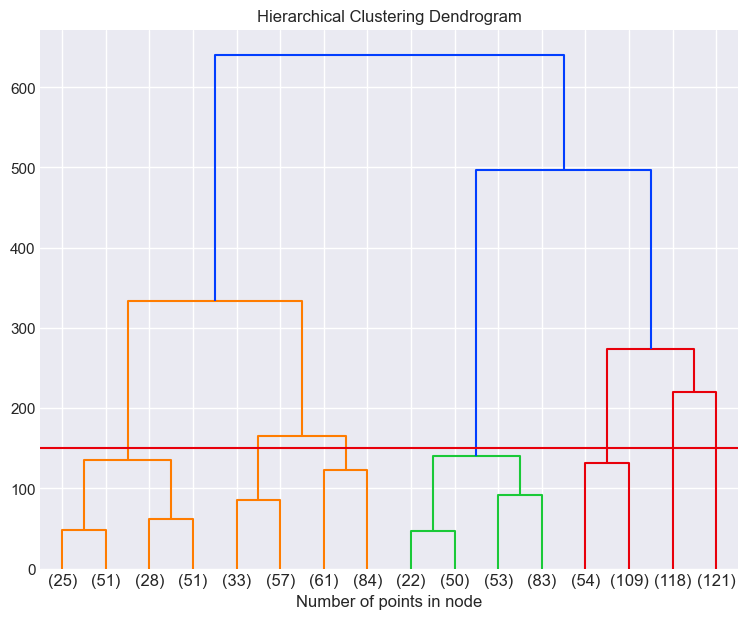

In [33]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # cCeate the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(tsne_features)

plt.figure(figsize = (9,7))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agg_cluster, truncate_mode='level', p=3)
plt.hlines(150, 0, 300, colors = 'r') # Plotting the clutering line with optimal seperation
plt.xlabel("Number of points in node")
plt.show()

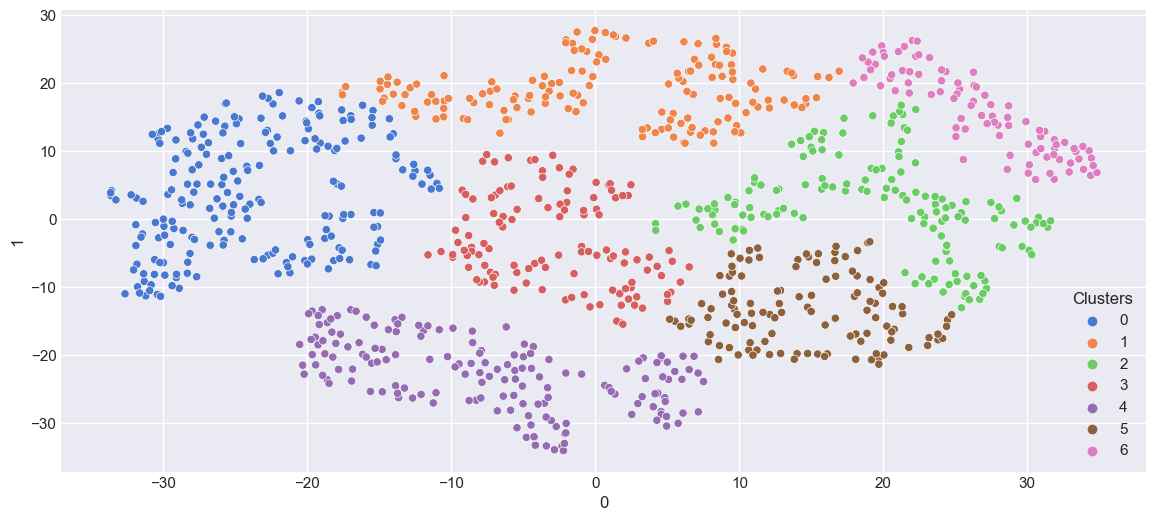

Silhouette Score(n=7): 0.365415096282959


In [34]:
hierarchical = AgglomerativeClustering(n_clusters=7)
hierarchical.fit_predict(tsne_features)

# Visualize the results
plt.figure(figsize=(14,6))

sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=hierarchical.labels_, palette='muted')
plt.legend(title='Clusters')
plt.show()
print(f'Silhouette Score(n=7): {silhouette_score(tsne_features, hierarchical.labels_)}')


<hr>

### GMM Clustering

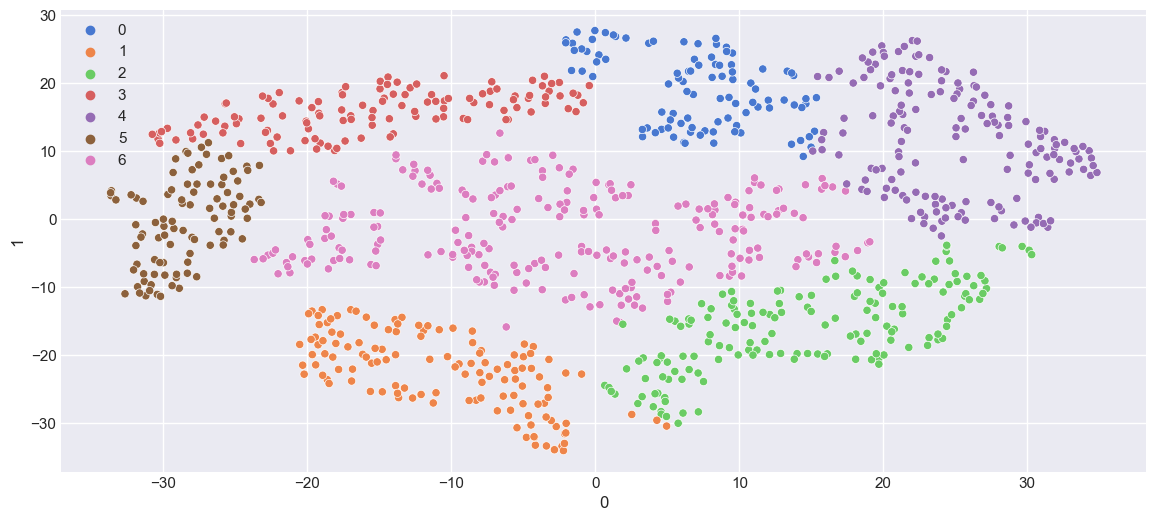

Silhouette Score(n=6): 0.33282119035720825


In [35]:
gmmModel = GaussianMixture(n_components=7, random_state=0)
gmmModel.fit(tsne_features)
labels = gmmModel.predict(tsne_features)

# Plotting
plt.figure(figsize=(14,6))
sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=labels, palette='muted')

plt.show()
print(f'Silhouette Score(n=6): {silhouette_score(tsne_features, labels)}')


<hr>

### Spectral Clustering
<hr>

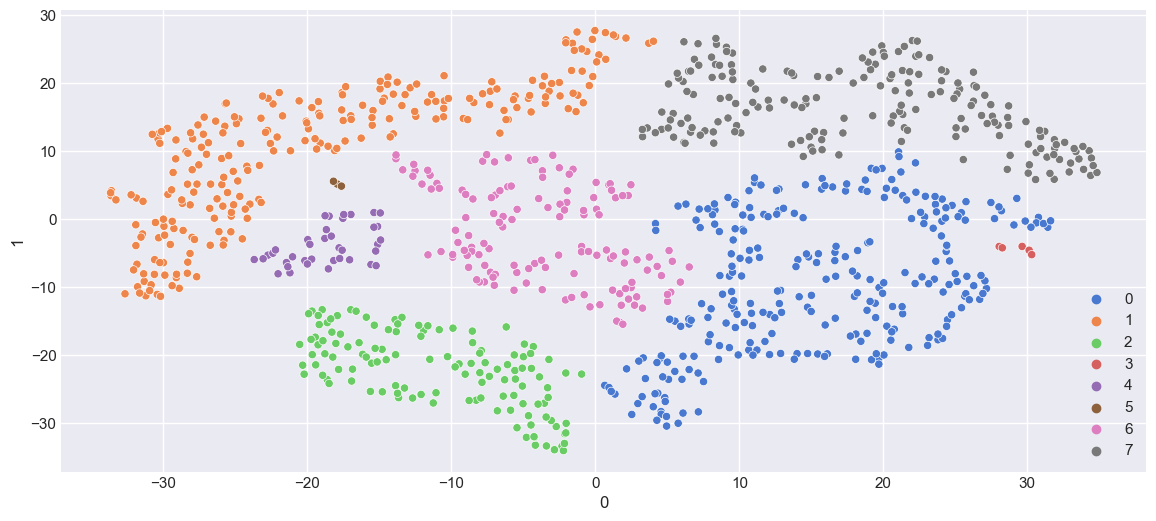

Silhouette Score(n=7): 0.07935073971748352


In [36]:
spectralClusteringModel = SpectralClustering(n_components=7, random_state=0)
spectralClusteringModel.fit(tsne_features)

# Plotting
plt.figure(figsize=(14,6))
sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=spectralClusteringModel.labels_, palette='muted')

plt.show()
print(f'Silhouette Score(n=7): {silhouette_score(tsne_features, spectralClusteringModel.labels_)}')

<hr>

### Hyperparameter tuning
<hr>

In [37]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

In [38]:
#KMeans Param Grid
param_grid = {
    'n_clusters': [7],
    'init': ['k-means++', 'random'],
    'max_iter': [150, 350, 550],
    'n_init': [15, 25, 35]
}

# Create an instance of KMeans and GridSearchCV
model = KMeans(random_state=42)
km_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1)

km_grid_search.fit(tsne_features)

print("Best Parameters:", km_grid_search.best_params_)
print("Best Score:", km_grid_search.best_score_)

Best Parameters: {'init': 'random', 'max_iter': 150, 'n_clusters': 7, 'n_init': 25}
Best Score: 0.41215566992759706


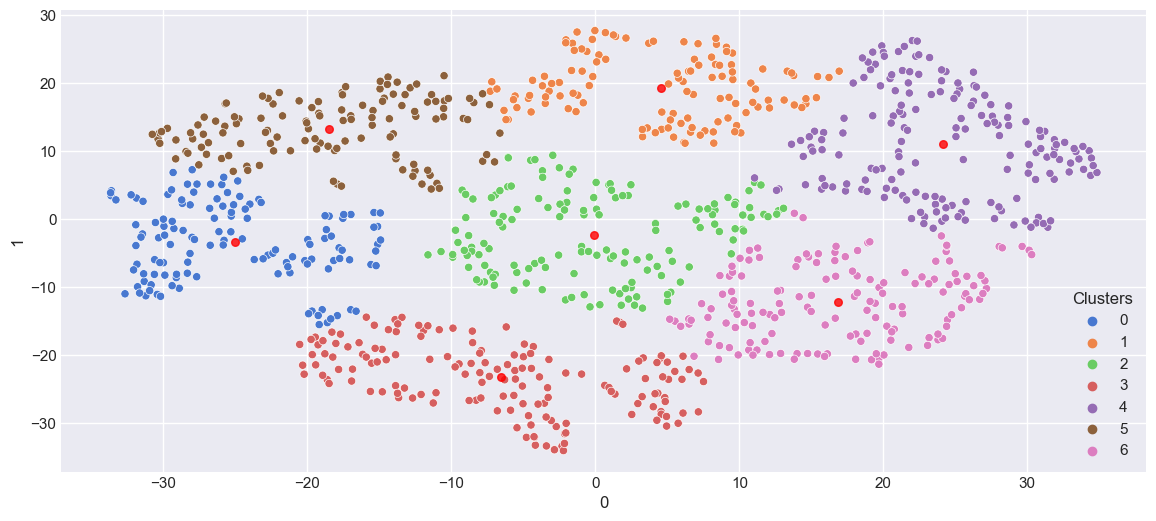

Silhouette Score(n=7): 0.4040564000606537


In [39]:
kmeans_hypertune_model = KMeans(init='random', max_iter= 150, n_clusters=7, n_init= 25)
kmeans_hypertune_model.fit(tsne_features)

# Visualize the results
plt.figure(figsize=(14,6))
sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=kmeans_hypertune_model.labels_, palette='muted')

centers = kmeans_hypertune_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=30, alpha=0.8)
plt.legend(title='Clusters')
plt.show()

print(f'Silhouette Score(n=7): {silhouette_score(tsne_features, kmeans_hypertune_model.labels_)}')

<hr>

### Intperating Clustering
<hr>

#### Final Model

Since our model remained the same we will stick 

In [40]:
df_eveluate = df.copy()
df_eveluate['Cluster'] = kmeans_hypertune_model.labels_

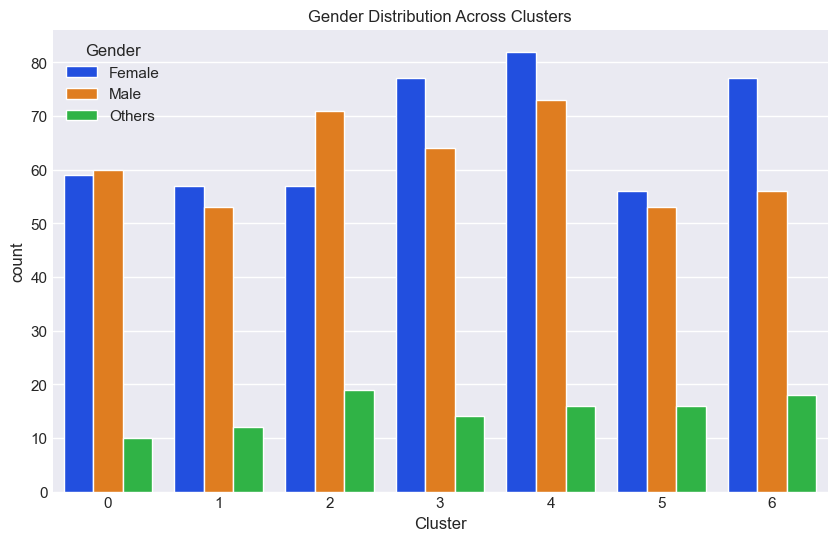

In [41]:
# Gender distribution in each cluster
plt.figure(figsize=(10,6))
plt.title('Gender Distribution Across Clusters')
sns.countplot(data=df_eveluate, x='Cluster', hue='Gender')

plt.show()

In [42]:
df_eveluate.drop(columns='Gender', inplace=True)

In [43]:
cluster_centers = df_eveluate.groupby('Cluster').mean().sort_values(by='Average score', ascending=False)
cluster_centers['Cluster Size (% of Total)'] = pd.Series(df_eveluate['Cluster']).value_counts() / len(df_eveluate['Cluster']) * 100

cluster_centers

,Age,English_Score,Math_Score,Science_Score,Average score,Cluster Size (% of Total)
Cluster,,,,,,
4,14.631579,90.871345,83.095242,79.812865,84.593151,17.1
6,16.490066,72.474946,82.529685,88.119205,81.041279,15.1
1,16.008197,88.754098,75.319528,68.852459,77.642028,12.2
2,13.224490,74.402481,70.376218,84.299320,76.359340,14.7
3,14.096774,61.683871,85.677193,77.716129,75.025731,15.5
5,14.864000,80.475584,67.098432,62.512000,70.028672,12.5
0,15.798450,63.730766,68.123895,67.937984,66.597548,12.9


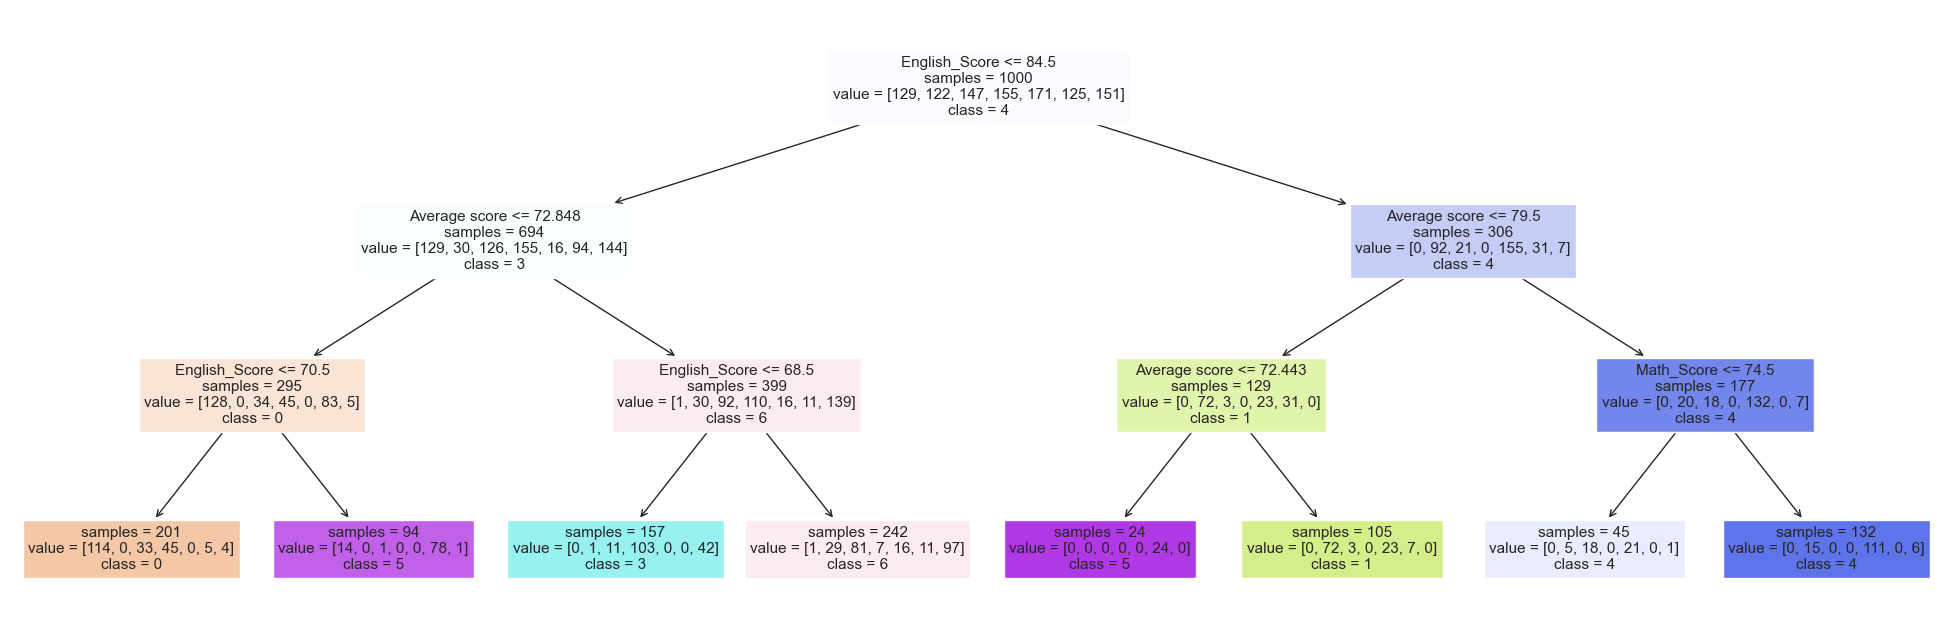

In [44]:
# Defining the model
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)
clf.fit(df_eveluate.drop(columns='Cluster'), df_eveluate['Cluster'])

# Plotting the decision tree
fig, ax = plt.subplots(figsize = (25,8))
plot_tree(
            clf,
            feature_names = df_eveluate.drop(columns='Cluster').columns,
            class_names= np.unique(df_eveluate['Cluster'].values.astype(str)),
            impurity=False,
            filled = True, 
            ax = ax, 
            fontsize=11
            )
plt.show()